<a href="https://colab.research.google.com/github/cagBRT/Diffusers/blob/main/diffusionclip_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enjoy DiffusionCLIP: Text-Guided Diffusion Models for __Robust__ Image Manipulation

<a href="https://colab.research.google.com/drive/1n50M3cEGyU6O1DyB791fz43RwnbavPS4?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We provide a colab notebook for you to play with DiffusionCLIP! Due to 12GB of the VRAM limit in Colab, we only provide the codes of inference & applications with the fine-tuned DiffusionCLIP models, not fine-tuning code. We provide a wide range of types of edits, and you can also upload your fine-tuned models following below instructions on Colab and test them.
- __Note: Due to the low performance of NVIDIA K80 GPU that is provided for free on Colab, foward-reverse processes can be slow. If RTX 2080ti or Quardro RTX 6000 are used, the processes can be accelerated as 10 times.__

# Setup
- This will install required packages and take a few minutes.
- __Pydrive__ enable to avoid Google Drive download limit but it takes more time when using it. If you have trouble with download limit, please run the notebook again and run setup with checking `download_with_pydrive`.

In [1]:
!pip install lmdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 5.4 MB/s eta 0:00:00


In [2]:
#@title Setup
import os
diffusionclip_dir = os.path.join("/content", "DiffusionCLIP")
from getpass import getpass

! git clone https://github.com/gwang-kim/DiffusionCLIP.git
os.chdir(f'./DiffusionCLIP')
os.makedirs("checkpoint", exist_ok=True)
os.makedirs("precomputed", exist_ok=True)
os.makedirs("pretrained", exist_ok=True)
os.makedirs("runs", exist_ok=True)

! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

from utils.colab_utils import GoogleDrive_Dowonloader
download_with_pydrive = False #@param {type:"boolean"}
dl = GoogleDrive_Dowonloader(download_with_pydrive)


from diffusionclip import DiffusionCLIP
from main import dict2namespace
import argparse
import yaml
from PIL import Image
import warnings
warnings.filterwarnings(action='ignore')

device = 'cuda'

%load_ext autoreload
%autoreload 2

Cloning into 'DiffusionCLIP'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 224 (delta 28), reused 29 (delta 26), pack-reused 184
Receiving objects: 100% (224/224), 25.87 MiB | 17.10 MiB/s, done.
Resolving deltas: 100% (92/92), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.7 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-m4jtrnlt
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-m4jtrnlt
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=590aad513bb39fda611f5caab070a24cc7c064942f0e590b19b2397b8b3afcdd
  Stored in directory: /tmp/pip-ephem-wheel-cache-1z_q8z74/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b11

# Manipulation of Images in Trained Domain & to Unseen Domain
You can edit one image into the CLIP-guided domain.
- Use the image path of samples in `./imgs` or use your uploaded image.
- We provide a wide range of `edit_type`, but you can also use your finetuned models by uploadint them in `./checkpoint`.
- You can control the degree of change by controling `degree_of_change` from 0.0 (no change) to 1.0 (full change).
- `n_inv_step` can be chosen in `[0, t_0]` where `t_0` is set depending on the finetuned models automatically  e.g. 4 ~ 200
- `n_test_step` can be chosen in `[0, n_inv_step]` e.g. 6, 12 for quick manipulation.
  - We found that the manipulation quality is better when n_***_step does not divide t_0. So we usally use 301, 401, 500 or 601 for t_0.
- Image is inverted to the latent once for each image at the first time. From the next time, the image is generated from the latent without the inversion.
- You can use your finetuned models by uploading them in `./checkpoint`.
- The models are downloaded once.
- The latent for the same image and `t_0` is calculated once.


pretrained/512x512_diffusion.pt exists.


Downloading...
From: https://drive.google.com/uc?id=1tyTTs2NuObhHbll9f6-mGQH1-4Mi0VG5
To: /content/DiffusionCLIP/checkpoint/tennis_orange_t500.pth
100%|██████████| 2.24G/2.24G [00:30<00:00, 74.1MB/s]


return step t_0: 500
None is loaded.
checkpoint/tennis_orange_t500.pth is loaded.
Latent exists.
Sampling type: DDIM with eta 0.0,  Steps: 12/500
Uniform skip type


Generative process 0: 100%|██████████| 12/12 [00:21<00:00,  1.79s/it]


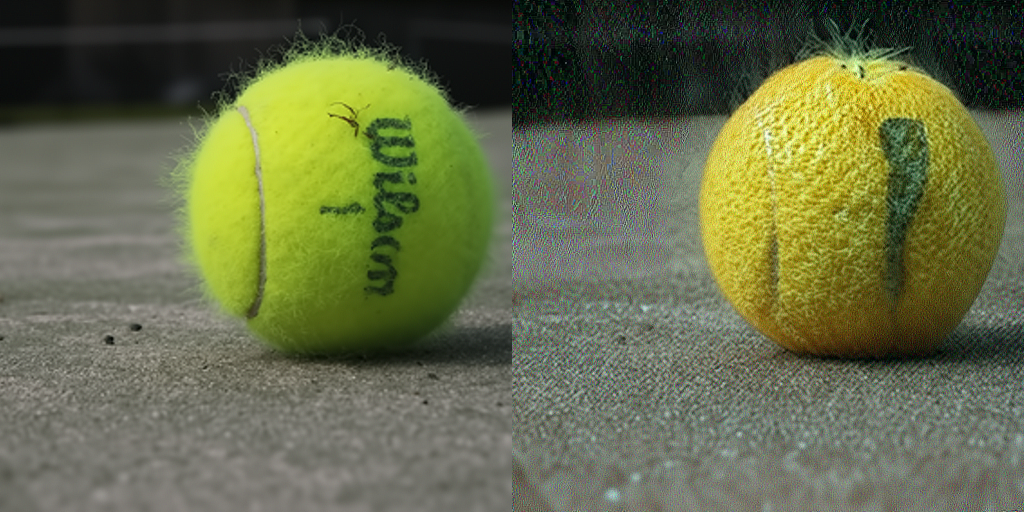

In [6]:
#@title Tennis Ball Manipulation (512x512)
#@markdown DiffusionCLIP can even perform manipulation of __512 × 512 images using the ImageNet__ pretrained diffusion models.
#@markdown Thanks to the near-perfect inversion capability, DiffusionCLIP enables the zero-shot text-driven manipulation, moving a step forward to the __general text-driven manipulation__.

#@markdown In contrast, due to the diversity of the images in ImageNet, __GAN-based inversion and its manipulation in the latent space of ImageNet shows limited performance__. Hence, zero-shot text-driven manipulation using ImageNet pretrained GAN have been rarely explored.

#@markdown You can use `imgs/tennis1.png`\~`imgs/tennis4.png` as `img_path`.

if not os.path.exists('pretrained/512x512_diffusion.pt'):
  ! wget -P pretrained/ https://openaipublic.blob.core.windows.net/diffusion/jul-2021/512x512_diffusion.pt
else:
  print('pretrained/512x512_diffusion.pt exists.')



img_path = 'imgs/tennis1.png'  #@param {type:"string"}
edit_type = 'Orange' #@param ['Baseball', 'Melon','Orange', 'Tomato']
degree_of_change = 0.61 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
tennis_gdrive_ids = {'Baseball':   ["1yGLsrGWkJJ9bRprBYLs8SQDzYG0x6yc1", "tennis_baseball_t500.pth"],
                     'Melon':      ["1-nGdHZ8sfyePQmOMRXV-c1yr8qHxFIdO", "tennis_melon_t500.pth"],
                     'Orange':     ["1tyTTs2NuObhHbll9f6-mGQH1-4Mi0VG5", "tennis_orange_t500.pth"],
                     'Tomato':     ["1iZOXEf8oZON1w_5p6a8Wh1AJRcvtfYEC", "tennis_tomato_t500.pth"],
                    }

gid = tennis_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', tennis_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
print(f'return step t_0: {t_0}')
exp_dir = f"runs/MANI_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)

# Test arg, config
n_inv_step = 40 #@param {type: "integer"}
n_test_step = 12 #@param [12]
args_dic = {
    'config': 'imagenet.yml',
    't_0': t_0,
    'n_inv_step': int(n_inv_step),
    'n_test_step': int(n_test_step),
    'sample_type': 'ddim',
    'eta': 0.0,
    'bs_test': 1,
    'model_path': model_path,
    'img_path': img_path,
    'deterministic_inv': 1,
    'hybrid_noise': 0,
    'n_iter': 1,
    'align_face': 0,
    'image_folder': exp_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.edit_one_image()

# Result
print()
n_result = 1
img = Image.open(os.path.join(exp_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
for i in range(n_result):
  img = Image.open(os.path.join(exp_dir, f"3_gen_t{t_0}_it0_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}_{model_path.split('/')[-1].replace('.pth','')}.png"))
  img = img.resize((int(img.width), int(img.height)))
  grid.paste(img, (int(img.height * (i+1)), 0))
grid


pretrained/512x512_diffusion.pt exists.


Downloading...
From: https://drive.google.com/uc?id=1Am1Iii7jH986XQUuVaDs4v5s1h_acg0w
To: /content/DiffusionCLIP/checkpoint/imagenet_pointillism_t601.pth
100%|██████████| 2.24G/2.24G [00:28<00:00, 77.5MB/s]


return step t_0: 601
None is loaded.
checkpoint/imagenet_pointillism_t601.pth is loaded.
Latent exists.
Sampling type: DDIM with eta 0.0,  Steps: 12/601
Uniform skip type


Generative process 0: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


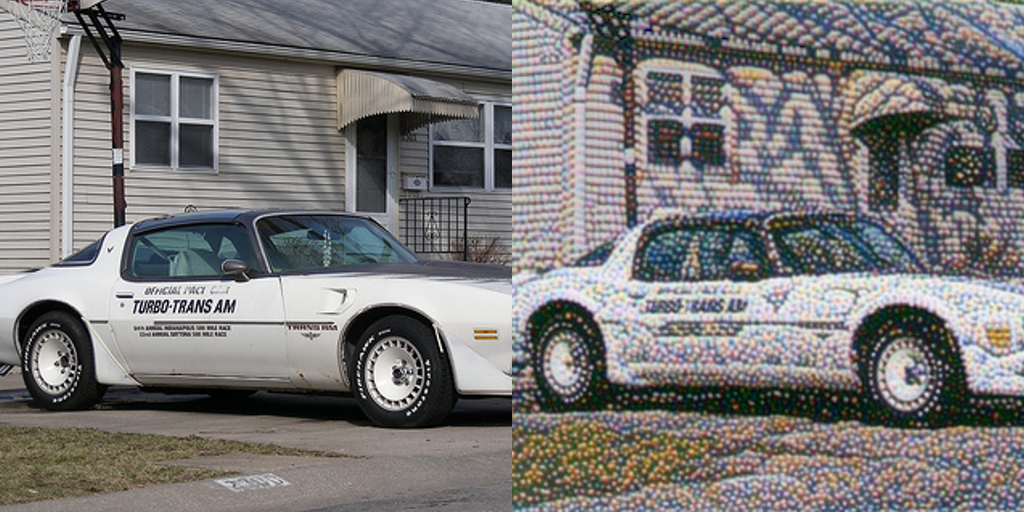

In [5]:
#@title ImageNet Style Transfer (512x512)
#@markdown You can use `imgs/general1.png`\~`imgs/general4.png` as `img_path`.

if not os.path.exists('pretrained/512x512_diffusion.pt'):
  ! wget -P pretrained/ https://openaipublic.blob.core.windows.net/diffusion/jul-2021/512x512_diffusion.pt
else:
  print('pretrained/512x512_diffusion.pt exists.')



img_path = 'imgs/imagenet1.png'  #@param {type:"string"}
edit_type = 'Pointillism art' #@param ['Watercolor art', 'Pointillism art','Painting by Gogh', 'Cubism art']
degree_of_change = 1 #param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
imagenet_gdrive_ids = {'Watercolor art':   ["1l1vLwdL-6kC9jKcStASZ0KtX2OrmrSj6", "imagenet_watercolor_t601.pth"],
                       'Pointillism art':  ["1Am1Iii7jH986XQUuVaDs4v5s1h_acg0w", "imagenet_pointillism_t601.pth"],
                       'Painting by Gogh': ["1ZPeOvMpFStw8RXJga_0pWLJ7iIWEQIVY", "imagenet_gogh_t601.pth"],
                       'Cubism art':       ["1xEx4_MXvbvtSqLzn6z49RUnPDFoDv9Vm", "imagenet_cubism_t601.pth"],
                      }

gid = imagenet_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', imagenet_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
print(f'return step t_0: {t_0}')
exp_dir = f"runs/MANI_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)

# Test arg, config
n_inv_step =  40#@param {type: "integer"}
n_test_step = 12#@param [12]
args_dic = {
    'config': 'imagenet.yml',
    't_0': t_0,
    'n_inv_step': int(n_inv_step),
    'n_test_step': int(n_test_step),
    'sample_type': 'ddim',
    'eta': 0.0,
    'bs_test': 1,
    'model_path': model_path,
    'img_path': img_path,
    'deterministic_inv': 1,
    'hybrid_noise': 0,
    'n_iter': 1,
    'align_face': 0,
    'image_folder': exp_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.edit_one_image()

# Result
print()
n_result = 1
img = Image.open(os.path.join(exp_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
for i in range(n_result):
  img = Image.open(os.path.join(exp_dir, f"3_gen_t{t_0}_it0_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}_{model_path.split('/')[-1].replace('.pth','')}.png"))
  img = img.resize((int(img.width), int(img.height)))
  grid.paste(img, (int(img.height * (i+1)), 0))
grid

